In [131]:
# Import Library
%reset
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from keras.preprocessing.image import ImageDataGenerator #, img_to_array, 
from tensorflow.keras.utils import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import os
import pickle
import warnings
warnings.filterwarnings("ignore")
from PIL import Image

# Prepare and Review Dataset

In [136]:
# Test and Train path
with open('newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

with open('AllPixelBand3.pickle', 'rb') as handle:
    allPixel3 = pickle.load(handle)

# Identificare qualita' e suddivisione del dataset in maniera corretta tra train e test

 Resa bassa: 58 Resa media[4500,10000]: 1472 Resa alta(>10000): 31


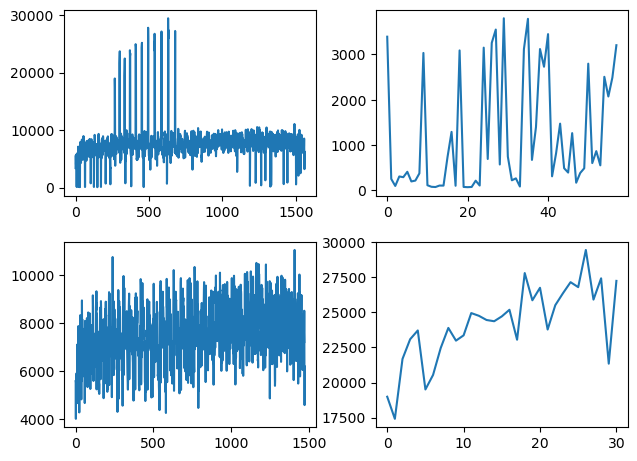

In [137]:
FilterResa3gtZero = newResa3!=0
newResa3 = newResa3[FilterResa3gtZero]
allPixel3 = allPixel3[FilterResa3gtZero,:,:]

LowValue = 1
Medium = 4000
HighValue = 12000
Resa3LowFilter = (newResa3<Medium) & (newResa3>LowValue)
Resa3MediumFilter = (newResa3>=Medium) & (newResa3<=HighValue)
Resa3HighFilter = (newResa3>HighValue)

Resa3Low = newResa3[Resa3LowFilter]
Resa3Medium = newResa3[Resa3MediumFilter]
Resa3High = newResa3[Resa3HighFilter]

Pixel3Low = allPixel3[Resa3LowFilter,:,:]
Pixel3Medium = allPixel3[Resa3MediumFilter,:,:]
Pixel3High = allPixel3[Resa3HighFilter,:,:]


print(" Resa bassa: "+str(len(Resa3Low))+ " Resa media[4500,10000]: "+ str(len(Resa3Medium))+ " Resa alta(>10000): "+ str(len(Resa3High)))

padding = 1.2
f, axarr = plt.subplots(2,2)
f.tight_layout(pad=padding)
axarr[0][0].plot(newResa3)
axarr[0][1].plot(Resa3Low)
axarr[1][0].plot(Resa3Medium)
axarr[1][1].plot(Resa3High)
plt.show()

In [138]:
def splitSet(X,Y):
    if X.shape[0] != Y.shape[0]:
        raise Exception("X and Y have different sizes")
    choice = np.random.choice(range(X.shape[0]), size=(int(X.shape[0]/2),), replace=False)
    ind = np.zeros(X.shape[0], dtype=bool)
    ind[choice] = True
    rest = ~ind
    return np.array(X[ind,:,:]),np.array(Y[ind]),np.array(X[rest,:,:]),np.array(Y[rest])

# Costruisco le immagini

[3089.9   73.6  569.8 3800.   744.   220.5   83.2  671.3 3120.1 2729. ]


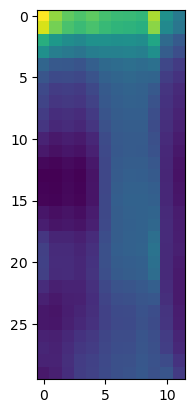

In [139]:
# Test and Train path
train_path = "dataset\\train\\"
test_path = "dataset\\test\\"

training_setLowX, training_setLowY, test_setLowX, test_setLowY = splitSet(Pixel3Low,Resa3Low)
training_setMediumX,training_setMediumY, test_setMediumX, test_setMediumY = splitSet(Pixel3Medium,Resa3Medium)
training_setHighX,training_setHighY, test_setHighX, test_setHighY = splitSet(Pixel3High,Resa3High)

training_setX = np.concatenate([training_setLowX,training_setMediumX,training_setHighX],axis=0)
training_setY = np.concatenate([training_setLowY,training_setMediumY,training_setHighY],axis=0)

test_setX = np.concatenate([test_setLowX,test_setMediumX,test_setHighX],axis=0)
test_setY = np.concatenate([test_setLowY,test_setMediumY,test_setHighY],axis=0)


print(training_setY[10:20])
plt.imshow(np.transpose(training_setX[0,:,:]))

#Train Set
for a in range(0,training_setX.shape[0]):
    img = Image.fromarray(training_setX[a,:,:])
    img.save(train_path+str(a)+'.tiff')

#Test Set
for a in range(0,test_setX.shape[0]):
    img = Image.fromarray(test_setX[a,:,:])
    img.save(test_path+str(a)+'.tiff')


In [140]:


# Costruiamo un dataframe Train
dFTrain = pd.DataFrame(columns=['id','target'])
dFTrain['id'] = [str(x)+".tiff" for x in list(range(0,training_setX.shape[0]))]
dFTrain['target'] = training_setY/newResa3.max()
print(dFTrain.head())

# Costruiamo un dataframe Test
dFTest = pd.DataFrame(columns=['id','target'])
dFTest['id'] = [str(x)+".tiff" for x in list(range(0,test_setX.shape[0]))]
dFTest['target'] = test_setY/newResa3.max()

# Prepare the dataset
#Train dataset
train_data = ImageDataGenerator().flow_from_dataframe(dataframe=dFTrain, target_size = (32,32),
                                                      directory=train_path,
                                                      x_col="id",
                                                      y_col="target",
                                                      class_mode="other")

#Test Dataset
test_data = ImageDataGenerator().flow_from_dataframe(dataframe=dFTest, target_size = (32,32),
                                                      directory=test_path,
                                                      x_col="id",
                                                      y_col="target",
                                                      class_mode="other")

       id    target
0  0.tiff  0.008520
1  1.tiff  0.010363
2  2.tiff  0.013866
3  3.tiff  0.006629
4  4.tiff  0.007274
Found 780 validated image filenames.
Found 781 validated image filenames.


In [141]:
print(dFTrain['target'].mean())
print(dFTrain['target'].median())

print(dFTest['target'].mean())
print(dFTest['target'].median())

0.2619604468345642
0.25931304693222046
0.263438880443573
0.26121047139167786


# Creazione del modello di Vgg16

In [142]:
# Import model
vgg16 = VGG16(input_shape=(32,32,3),include_top=False)

# Import model
#vgg16 = VGG16()

In [143]:
# layers of vgg16
vgg16_layer_list = vgg16.layers
for i in vgg16_layer_list:
    print(i)

In [144]:
# add the layers of vgg16 in my created model.
vgg16Model = Sequential()
for i in range(len(vgg16_layer_list)-1):
    vgg16Model.add(vgg16_layer_list[i])

In [145]:
# Close the layers of vgg16
for layers in vgg16Model.layers:
    layers.trainable = False

In [146]:
# Last layer
#vgg16Model.add(Dense(units=1))

vgg16Model.add(Dense(units=1))

In [147]:
# After I added last layer in created model.
vgg16Model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)        

In [148]:
# I create compile part.
vgg16Model.compile(loss = "mean_squared_error",
             optimizer = "rmsprop",
             metrics = ["mse","mae"])

# Training Model 

In [170]:
# Traning with model
batch_size = 32

hist_vgg16 = vgg16Model.fit(train_data, 
                                epochs = 20,
                                validation_data=test_data
                                )

Epoch 1/20
25/25 [==============================] - 4s 167ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0595 - val_loss: 0.0100 - val_mse: 0.0100 - val_mae: 0.0522
Epoch 2/20
25/25 [==============================] - 4s 157ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0590 - val_loss: 0.0100 - val_mse: 0.0100 - val_mae: 0.0510
Epoch 3/20
25/25 [==============================] - 4s 153ms/step - loss: 0.0112 - mse: 0.0112 - mae: 0.0618 - val_loss: 0.0102 - val_mse: 0.0102 - val_mae: 0.0524
Epoch 4/20
25/25 [==============================] - 4s 153ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0575 - val_loss: 0.0103 - val_mse: 0.0103 - val_mae: 0.0554
Epoch 5/20
25/25 [==============================] - 4s 157ms/step - loss: 0.0108 - mse: 0.0108 - mae: 0.0558 - val_loss: 0.0108 - val_mse: 0.0108 - val_mae: 0.0600
Epoch 6/20
25/25 [==============================] - 4s 159ms/step - loss: 0.0104 - mse: 0.0104 - mae: 0.0565 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0664
Epoch 7/20
25/25

In [171]:
# Save the weights of model
vgg16Model.save_weights("previsioneResa.h5")

# Andiamo a visualizzare i risultati della rete

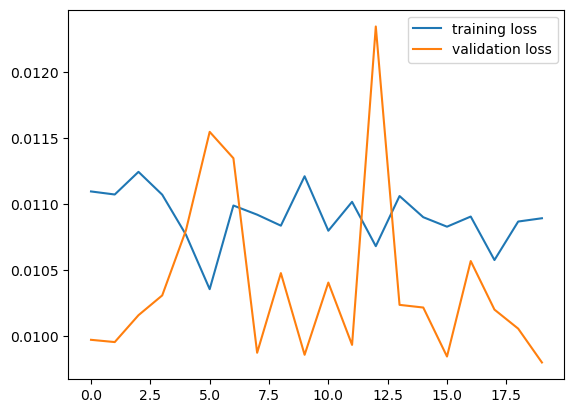

In [172]:
# Loss and Validation Loss
plt.plot(hist_vgg16.history["loss"], label = "training loss")
plt.plot(hist_vgg16.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

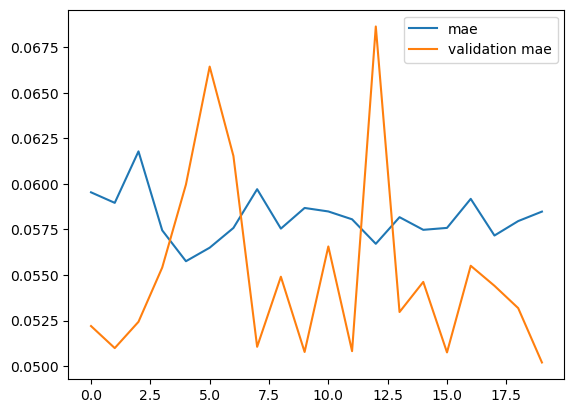

In [173]:
# Accuracy and Validation Accuracy
plt.plot(hist_vgg16.history["mae"], label = "mae")
plt.plot(hist_vgg16.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()

# Salviamo e carichiamo i risultati

In [153]:
import json, codecs
with open("previsioneResa.json","w") as f:
    json.dump(hist_vgg16.history, f)

In [154]:
with codecs.open("./previsioneResa.json","r", encoding = "utf-8") as f:
    load_result = json.loads(f.read())

In [155]:
load_result

{'loss': [0.01352838333696127,
  0.011606438085436821,
  0.011440054513514042,
  0.011078164912760258,
  0.011324441060423851,
  0.011290292255580425,
  0.010704654268920422,
  0.011048355139791965,
  0.010813633911311626,
  0.011011956259608269],
 'mse': [0.01352838333696127,
  0.011606438085436821,
  0.011440054513514042,
  0.011078164912760258,
  0.011324441060423851,
  0.011290292255580425,
  0.010704654268920422,
  0.011048355139791965,
  0.010813633911311626,
  0.011011956259608269],
 'mae': [0.07281213253736496,
  0.06397172808647156,
  0.06107514351606369,
  0.0613403357565403,
  0.06028968095779419,
  0.05990223586559296,
  0.05720280483365059,
  0.059533726423978806,
  0.057930558919906616,
  0.05998128280043602],
 'val_loss': [0.011523130349814892,
  0.010483344085514545,
  0.0103064039722085,
  0.010084027424454689,
  0.012669308111071587,
  0.01013901922851801,
  0.010311037302017212,
  0.010315816849470139,
  0.017051447182893753,
  0.011980143375694752],
 'val_mse': [0.0

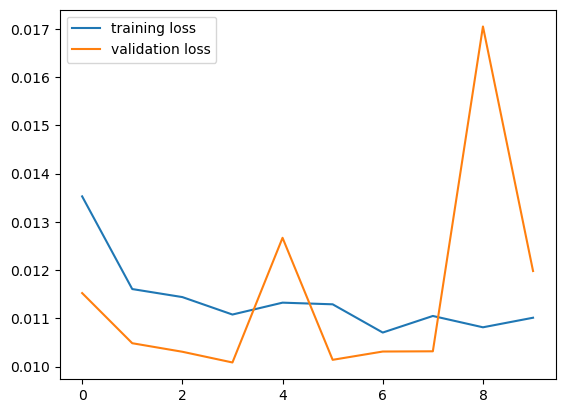

In [156]:
# Loss And Validation Loss
plt.plot(load_result["loss"], label = "training loss")
plt.plot(load_result["val_loss"], label = "validation loss")
plt.legend()
plt.show()

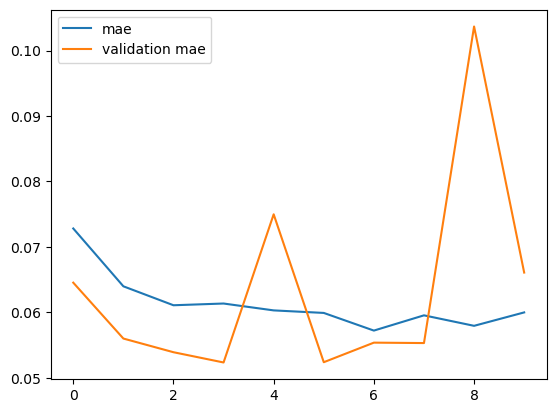

In [157]:
plt.plot(load_result["mae"], label = "mae")
plt.plot(load_result["val_mae"], label = "validation mae")
plt.legend()
plt.show()

# Vgg19

In [158]:
# Import VGG19 model
vgg19 = VGG19(input_shape=(32,32,3),include_top=False)

In [159]:
# Layers of vgg19
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [160]:
# Layers of vgg19 
vgg19_layer_list = vgg19.layers
for i in vgg19_layer_list:
    print(i)

In [161]:
# add the layers of vgg16 in my created model.
vgg19Model = Sequential()
for i in range(len(vgg19_layer_list)-1):
    vgg19Model.add(vgg19_layer_list[i])

In [162]:
# Finish version of my created model.
vgg19Model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)        

In [163]:
# Close the layers of vgg16
for layers in vgg19Model.layers:
    layers.trainable = False

In [164]:
# Last layer
vgg19Model.add(Dense(1))

In [165]:
# the final version of the model
vgg19Model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)        

In [166]:
# I create compile part.
vgg19Model.compile(loss = "mean_squared_error",
             optimizer = "rmsprop",
             metrics = ["mse","mae"])

# Addestramento

In [167]:
# Traning with model
batch_size = 32

# Training with my created model
hisy_vgg19 = vgg19Model.fit_generator(train_data,
                               epochs = 20,
                               validation_data = test_data
                               )

Epoch 1/20
25/25 [==============================] - 6s 201ms/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1508 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.0961
Epoch 2/20
25/25 [==============================] - 5s 189ms/step - loss: 0.0154 - mse: 0.0154 - mae: 0.0837 - val_loss: 0.0124 - val_mse: 0.0124 - val_mae: 0.0693
Epoch 3/20
25/25 [==============================] - 5s 191ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0717 - val_loss: 0.0113 - val_mse: 0.0113 - val_mae: 0.0625
Epoch 4/20
25/25 [==============================] - 5s 191ms/step - loss: 0.0118 - mse: 0.0118 - mae: 0.0653 - val_loss: 0.0107 - val_mse: 0.0107 - val_mae: 0.0571
Epoch 5/20
25/25 [==============================] - 5s 202ms/step - loss: 0.0115 - mse: 0.0115 - mae: 0.0622 - val_loss: 0.0126 - val_mse: 0.0126 - val_mae: 0.0736
Epoch 6/20
25/25 [==============================] - 5s 206ms/step - loss: 0.0118 - mse: 0.0118 - mae: 0.0637 - val_loss: 0.0109 - val_mse: 0.0109 - val_mae: 0.0606
Epoch 7/20
25/25

# Visualizziamo i risultati ottenuti

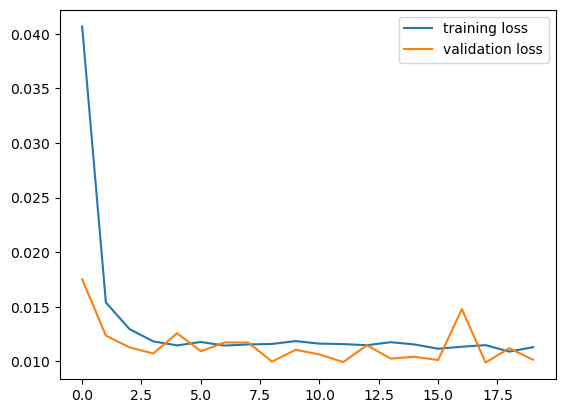

In [168]:
# Loss And Validation Loss
plt.plot(hisy_vgg19.history["loss"], label = "training loss")
plt.plot(hisy_vgg19.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

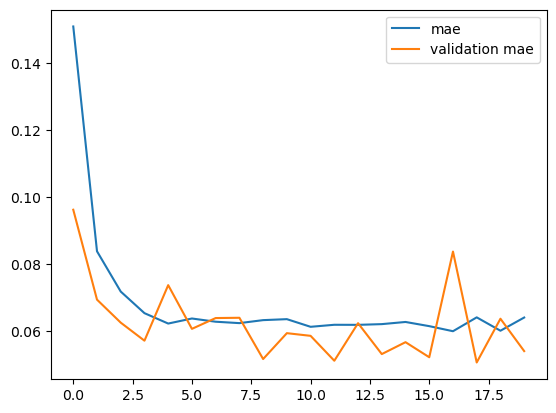

In [169]:
# Accuracy And Validation Accuracy
plt.plot(hisy_vgg19.history["mae"], label = "mae")
plt.plot(hisy_vgg19.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()